In [3]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [5]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 2.3918],
         [-1.0742]]),
 tensor([[ 1.0000e+00,  2.3918e+00,  2.8602e+00,  2.2803e+00,  1.3635e+00,
           6.5223e-01,  2.5999e-01,  8.8834e-02,  2.6559e-02,  7.0580e-03,
           1.6881e-03,  3.6704e-04,  7.3156e-05,  1.3459e-05,  2.2994e-06,
           3.6664e-07,  5.4807e-08,  7.7108e-09,  1.0246e-09,  1.2898e-10],
         [ 1.0000e+00, -1.0742e+00,  5.7698e-01, -2.0660e-01,  5.5484e-02,
          -1.1920e-02,  2.1342e-03, -3.2752e-04,  4.3978e-05, -5.2492e-06,
           5.6388e-07, -5.5067e-08,  4.9295e-09, -4.0734e-10,  3.1255e-11,
          -2.2383e-12,  1.5028e-13, -9.4961e-15,  5.6672e-16, -3.2041e-17]]),
 tensor([10.9294,  0.5560]))

In [6]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [7]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9914403  1.2552228 -3.3718803  5.506146 ]]


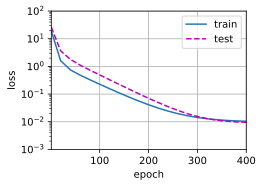

In [8]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.7135584 3.3591835]]


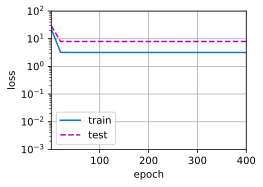

In [9]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9956703   1.2714576  -3.3508205   5.2477293  -0.27251416  1.3283114
  -0.04138601 -0.02619808  0.05071313  0.12815614  0.04761494  0.20627809
  -0.16528165 -0.1680694   0.05887532  0.20832872  0.14779387  0.13770674
  -0.18218169  0.14903909]]


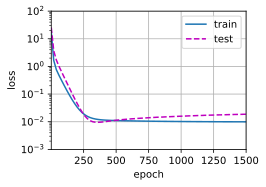

In [12]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)